Myllee Sarleth Mosquera Rivas - Multilayer Neural Network

***Estructura de la red neuronal***

n: Cantidad de variables de entrada\
n_hidden = $[i, j, k]$ -> Número de neuronas por cada capa (Cada entrada indica una capa con L neuronas)\
n_outputs: Cantidad de Salidas

n → i → j → k → n_outputs

***Inicialización de las matrices***

Weights: Matriz de pesos (Es una matriz de matrices de pesos por capa)\
Derivates: Matriz de cambio de los pesos:
  *   Para la última capa: Δ$w_k$ = $e_k𝚽_k'(v_{k})y_j$
  *   Capas ocultas: Δ$w_j$ = $𝚽_j'(v_{j})y_i\sum_k (e_k𝚽_k'(v_{k}))$



In [110]:
"Data Reading: Database: 'datosimulacionB.mat' "

from scipy.io import loadmat
import numpy as np
data = loadmat('datosimulacionB.mat')
datos = [data['Xv'], data['X'], data['Xs'], data['OD'], data['Ss']]
data_array = np.column_stack(datos)
#f = np.random.choice(data_array.shape[0], size=50, replace=False)
#data_array = data_array[f]
inputs1 = data_array[:,:4]
labels = data_array[:,-1:]

In [106]:
from re import L
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import random


"Campo: V = wX"
def camp(x, w):
    return np.dot(x, w)

"Sigmoid Activation Function"
def sigmoid(z):
    return 1/(1 + np.exp(-z))

"Derivative of the Sigmoid Function"
def sigmoid_derivated(z):
    return z*(1-z)

"Cost function"
def Cost_function(output, y):
    return np.mean((output - y)**2)/2

"""Matrix Initialization:
   Weights: Matrix of weights (It is a matrix of weight matrices per layer).
   Derivates: Matrix of weight change
   Activations: Matrix of lists of activations per neurons in each Layer"""

def Matrix_Initialization(n, n_hidden, n_outputs):
    #Layers: [n, i,j,k,n_outputs]
    layers = [n] + n_hidden + [n_outputs]
    weights = []
    derivates = []
    local_gradients = []
    """For each layer, a matrix is created with dimensions: rows: Neurons in current layer and columns: neurons in next layer"""
    for i in range(len(layers)-1):
        #Initialization of weights with an uniform randomly
        w = np.random.uniform(size=(layers[i], layers[i+1]))
        # Derivates
        d = np.zeros((layers[i], layers[i+1]))
        #Gradients
        gd = np.zeros((layers[i], layers[i+1]))
        #Add the matrix of each layer
        weights.append(w)
        derivates.append(d)
        local_gradients.append(gd)

    #Activation initialization: Neuron outputs
    activations = []
    for i in range(len(layers)):
        a = np.zeros((1, layers[i]))
        activations.append(a)

    return activations, weights, derivates, layers, local_gradients


def forward(inputs, activations,weights, derivates, layers):
    #The First activation are the inputs
    activations[0] = inputs
    #Calculate the camp in the first hidden with random weights
    z = camp(activations[0], weights[0])
    #Calculate the output (Activation) of the first hidden layer
    y_aux = sigmoid(z)
    #Save the activation
    activations[1] = y_aux
    #Propagation for the rest of the layers.
    for j in range(len(layers)-2):
        #Calculate the camp
        z = camp(y_aux, weights[j+1])
        #Calculate the output(Activation)
        y_aux = sigmoid(z)
        activations[j+2] = y_aux
        #Return the activation of the output layer.
    return activations[-1]


def Back_propagations(learning, weights, layers, activations, labels, derivates, local_gradients, list_gradients):
    #List for enumerating the layers
    back = list(range(len(layers)-1))
    #The list is reversed to process the layers from back to front.
    back.reverse()
    """
      y_current -----> (Layer)------> y_aux
    """
    for i in back:
        #Output of the current layer
        y_aux = activations[i+1]
        #Input of the current layer
        y_current = activations[i]
        #Local gradient and weights update for the output layer
        if i == np.max(back):
            #Calculate the error
            error = y_aux - labels
            #Local gradient (delta)
            #delta = error*sigmoid_derivated(y_aux)
            delta = np.multiply(error, sigmoid_derivated(y_aux)).reshape((1, len(error)))
            #Due to how the data was read, reshaping is needed to maintain the appropriate matrix structure.
            #Add delta to the matrix local_gradients
            local_gradients[i] = delta
            #error*derivada*salida capa anterior
            #Reshape y_current
            y_current = y_current.reshape((len(y_current),1))
            #Calculate delta(w)
            d = np.dot(y_current, delta)
            #Add delta(w) to the matrix derivates
            derivates[i] = d
            #Update the weights via gradient descent
            #Only send the weight and derivates of the actual layer
            weights[i] = Gradient_descent(learning, weights[i], derivates[i])

            """One stopping condition is that the local gradient of the output layer changes little
            within a band around 0.01, so here we set the stopping condition."""

            #if len(list_gradients[i])>2 and any(np.abs(list_gradients[i][-1] - delta)<0.01):

            if len(list_gradients[i])>2 and all(np.abs(list_gradients[i][-1][0] - delta[0])<0.01):
                #That returns True if the stopping condition is met.
                  return derivates, local_gradients, list_gradients, True
            #Add the local gradient to list_gradients
            list_gradients[i].append(delta)

        #Local gradient and weights update for the hidden layer
        else:
            #Local gradient (delta)
            delta = sigmoid_derivated(y_aux)*np.sum(local_gradients[i+1]*weights[i+1])
            #Reshape delta
            delta = delta.reshape((1, len(delta)))
            #Add delta to gradients matrix
            local_gradients[i] = delta
            #Add the local gradient to list_gradients
            list_gradients[i].append(delta)
            y_current = y_current.reshape(len(y_current), 1)
            #Calculate delta(w)
            d = (delta * y_current)
            derivates[i] = d
            #Update weights
            weights[i] = Gradient_descent(learning, weights[i], derivates[i])
    return derivates, local_gradients, list_gradients, False

"""Through gradient descent, weight updates are performed for each layer individually"""
def Gradient_descent(learning, weights, derivates):
    #Weight update
    w = weights
    #Local gradient * Last activation values
    d = derivates
    # w = w - d*learning
    w-= d*learning
    #Update weights
    weights = w

    return weights


def Red(n_inputs, n_outputs, data_array, activations, weights, derivates, layers, learning, local_gradients, epochs):
    #Epoch counter
    i=0
    #List to save the energy errors, usign the cost function
    errors = []
    #For each layer there is a empty list to save the gradients of its neurons
    list_gradients= [[] for _ in layers]
    while i <epochs:
        #Select a random patron
        patron = random.choice(data_array)
        #Select the inputs
        #inputs = patron[0:4]
        inputs = patron[0:n_inputs]
        #Select the outputs
        if n_outputs == 1:
           labels = patron[-1]
        else:
           labels = patron[3:5]
        #Output of the neural network
        output = forward(inputs, activations,weights, derivates, layers)
        #Weights update
        derivates, local_gradients, list_gradients, boolean = Back_propagations(learning, weights, layers, activations, labels, derivates,local_gradients, list_gradients)
        #Evaluate the stop condition
        if boolean == True:
            break
        #Calculate the error
        err = Cost_function(output, labels)
        errors.append(err)
        i+=1
    print("WEIGHTS MATRIX", weights)
    print("LOCAL GRADIENT MATRIX", local_gradients)
    print("DERIVATES MATRIZ", derivates)
    return list_gradients, output, weights, local_gradients, derivates, errors

epochs = 50
"""In this case, we're using the first 3 or 4 columns as inputs, and the last 2 or the last column as outputs. Therefore:
    - If the number of inputs is 3, then the number of outputs is 2.
    - If the number of inputs is 4, then the number of outputs is 1.
"""
n_inputs = 1
n_outputs = 1
#Inicialization matrix
activations, weights, derivates, layers, local_gradients = Matrix_Initialization(n_inputs, n_hidden=[3,5,4], n_outputs = n_outputs)
list_gradients, output, weights, local_gradients, derivates, errors = Red(n_inputs, n_outputs, data_array, activations, weights, derivates, layers, 0.1, local_gradients, epochs)


WEIGHTS MATRIX [array([[-0.03499412,  0.76764812,  0.48099223]]), array([[0.86086739, 0.83228736, 0.81629828, 0.08373737, 0.87737389],
       [0.18775477, 0.07328713, 0.12221461, 0.88463061, 0.12410467],
       [0.55792679, 0.57903321, 0.91793186, 0.25480785, 0.68476142]]), array([[0.86504249, 0.40008019, 0.91144859, 0.53127343],
       [0.08215698, 0.71690414, 0.9911998 , 0.15121566],
       [0.91784259, 0.32421443, 0.57099026, 0.77796105],
       [0.00678088, 0.69198283, 0.89254857, 0.00503602],
       [0.02317269, 0.12116236, 0.68890764, 0.87852719]]), array([[0.52531913],
       [0.98984672],
       [0.75259173],
       [0.79081285]])]
LOCAL GRADIENT MATRIX [array([[-0.01588301, -0.01563334, -0.01578477]]), array([[-0.00810755, -0.00831744, -0.00765756, -0.00858159, -0.00797531]]), array([[-0.00538302, -0.00474985, -0.00176756, -0.00440504]]), array([[-0.01056408]])]
DERIVATES MATRIZ [array([[-0.00522476, -0.00514263, -0.00519244]]), array([[-0.00403009, -0.00413442, -0.00380641, -

In [111]:
"""Model prediction"""
inputs1 = data_array[:,:n_inputs]
if n_outputs == 1:
    labels = data_array[:,-1:]
else:
    labels = data_array[:,3:5]

from sklearn.metrics import mean_absolute_percentage_error
output = forward(inputs1, activations,weights, derivates, layers)
error = mean_absolute_percentage_error(output, labels)
print("%ERROR:", error)

%ERROR: 0.5320917825668551


Training and learning curves: Local Gradients and error energies

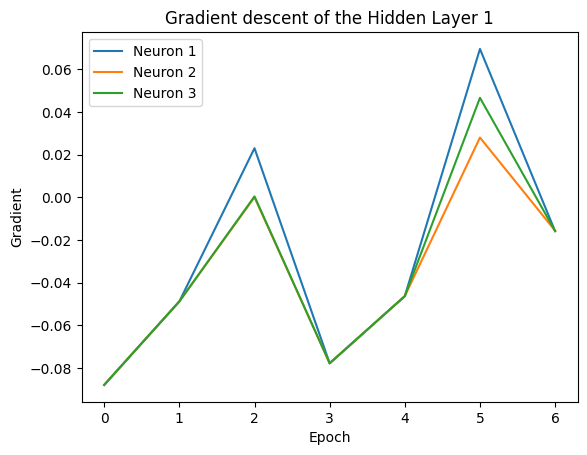

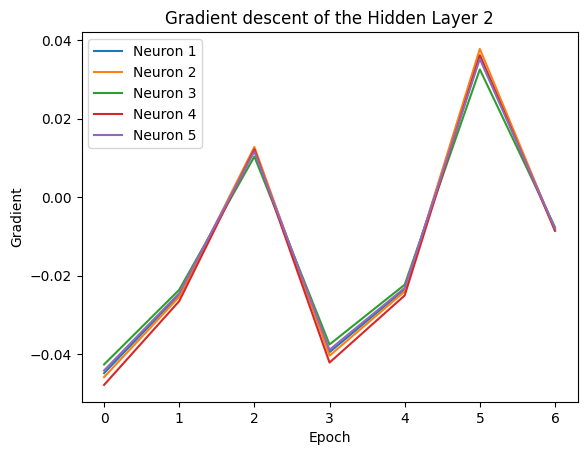

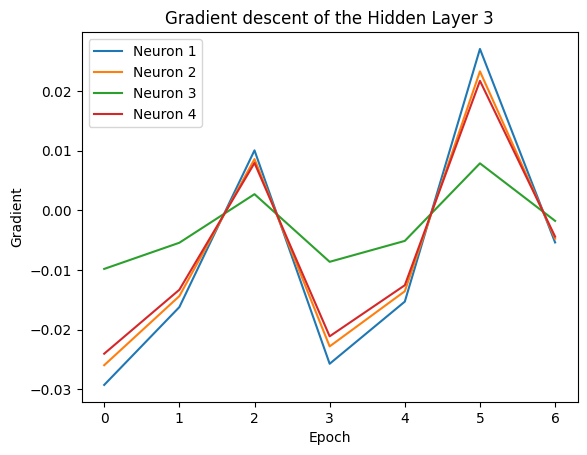

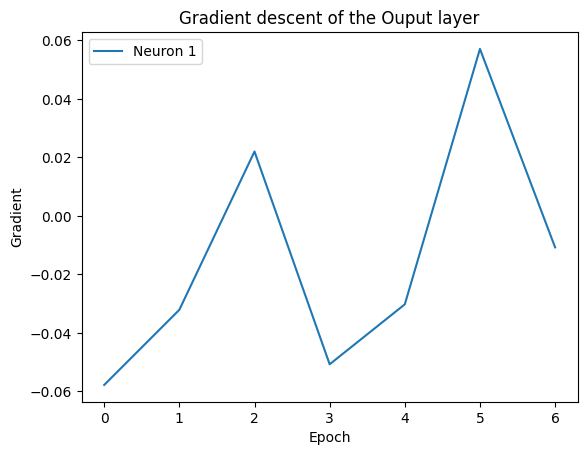

In [112]:
j = 1
for i in list_gradients[:-1]:

    i = np.array(i)
    g = i.reshape((len(i),i.shape[2]))
    for i in range(g.shape[1]):
        plt.plot(g[:,i],  label=f'Neuron {i+1}')
    if g.shape[1]==labels.shape[1]:
      layer = "Ouput layer"
    else:
      layer = "Hidden Layer " + str(j)
      j+=1
    plt.title("Gradient descent of the " + layer)
    plt.ylabel("Gradient")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()


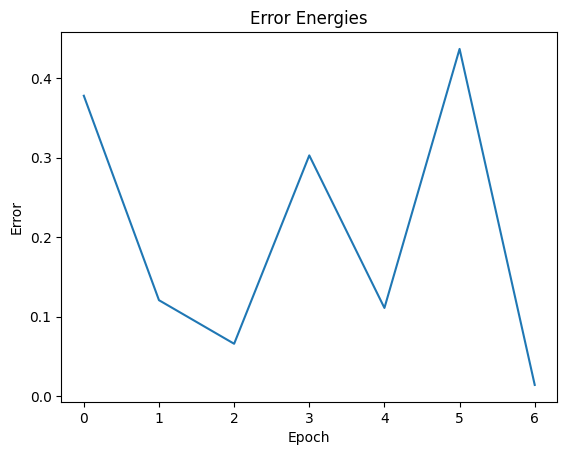

In [113]:
plt.plot(errors)
plt.title("Error Energies")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()